In [114]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [116]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import *

# Reflect Tables into SQLAlchemy ORM

In [117]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [118]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn=engine.connect()


In [119]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)
# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [120]:
#create the inspector
inspector = inspect(engine)

In [121]:
# View all of the classes that automap found

# Inspect the tables to see column names and class - measurement
print("measurement")
print("----------------------------------")
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])
print("----------------------------------")
print("station")
print("----------------------------------")
#Inspect the tables to see column names and class - station
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])


measurement
----------------------------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
----------------------------------
station
----------------------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [122]:
# Save references to each table
measurement_table = Base.classes.measurement
station_table = Base.classes.station

In [123]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [139]:
# Find the most recent date in the data set.

recent_date = session.query(measurement_table.date).\
    order_by(desc(measurement_table.date)).first()

recent_date

#the most recent date in the data set is 2017-08-23

('2017-08-23',)

<AxesSubplot:xlabel='Date', ylabel='Inches'>

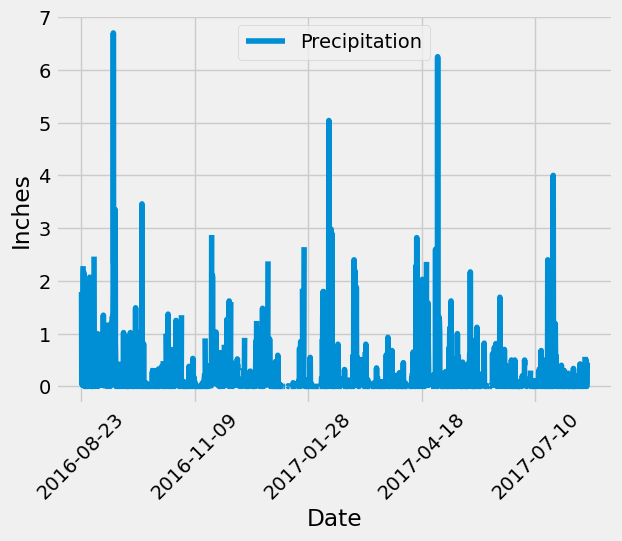

In [169]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database. 
# recent_date = dt.date(2017,8,23)

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017,8,23) - relativedelta(months=12)

# Perform a query to retrieve the data and precipitation scores
year_prcp_query = session.query(measurement_table.date, measurement_table.prcp).\
    filter(measurement_table.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df_year_prcp = pd.DataFrame(year_prcp_query)
df_year_prcp.columns = ['Date','Precipitation']
df_year_prcp = df_year_prcp.set_index(['Date'])

# Sort the dataframe by date
df_year_prcp.sort_index(inplace=True, ascending=True)
df_year_prcp.head()

# Use Pandas Plotting with Matplotlib to plot the data

df_year_prcp.plot(kind = 'line', y='Precipitation', ylabel='Inches', rot=45)


In [126]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_year_prcp.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [138]:
# Design a query to calculate the total number stations in the dataset
station_count_query = session.query(station_table.station).group_by(station_table.station).count()

print(f'There are a total of {station_count_query} stations')

There are a total of 9 stations


In [157]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

station_activity_query = session.query(measurement_table.station, func.count(measurement_table.station)).\
    group_by(measurement_table.station).\
    order_by(desc(func.count(measurement_table.station))).all()

station_activity_query



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [159]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

active_station_stats = session.query(func.min(measurement_table.tobs),
                                     func.max(measurement_table.tobs),
                                     func.avg(measurement_table.tobs)).\
                                        filter((measurement_table.station) == 'USC00519281').all()
                                        
active_station_stats

[(54.0, 85.0, 71.66378066378067)]

<AxesSubplot:title={'center':'Frequency of Temperature Observations for Station USC00519281'}, ylabel='Frequency'>

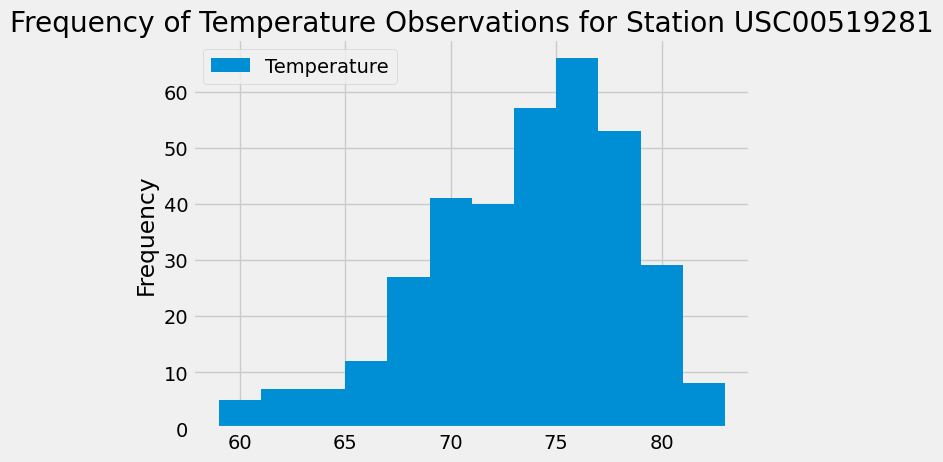

In [173]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

year_active_temp_query = session.query(measurement_table.date, measurement_table.tobs).\
    filter(measurement_table.date >= query_date).\
    filter(measurement_table.station == 'USC00519281').all()
    
df_year_active_temp = pd.DataFrame(year_active_temp_query)

df_year_active_temp.columns = ['Date', 'Temperature']
df_year_active_temp = df_year_active_temp.set_index(['Date'])

df_year_active_temp.sort_index(inplace= True, ascending=True)

df_year_active_temp.plot(kind='hist',y='Temperature', xlabel='Temperature', title= 'Frequency of Temperature Observations for Station USC00519281', bins=12)

# Close session

In [171]:
# Close Session
session.close()